# Load the data 

In [1]:
from datasets import load_dataset

# Load the emotion dataset
dataset = load_dataset("emotion")
print(dataset["train"][0])


{'text': 'i didnt feel humiliated', 'label': 0}


In [2]:
label_names = dataset['train'].features['label'].names
print(label_names)


['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


# Run embedding 

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")


/home/silva/HandsOnLLM/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/usr'
/home/silva/HandsOnLLM/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
train_data = dataset["train"]
val_data = dataset["validation"]

# Encode sentences
X_train = model.encode(train_data["text"], show_progress_bar=True, batch_size=32)
X_val = model.encode(val_data["text"], show_progress_bar=True, batch_size=32)

# Labels
y_train = train_data["label"]
y_val = val_data["label"]


Batches:   0%|          | 0/500 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) 

# Try classification with embeddings
# - Use the embeddings to classify the text 

In [6]:
# 📦 Imports

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# ✅ Define classifiers
models = {
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=1000),
    "SVM": SVC(class_weight="balanced", probability=True),
    "RandomForest": RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42),
}

# 🚀 Train and evaluate each model
for name, model in models.items():
    print(f"\n🔧 Training: {name}")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    print(f"📊 {name} - Classification Report:")
    print(classification_report(y_val, y_pred))



🔧 Training: LogisticRegression
📊 LogisticRegression - Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       550
           1       0.84      0.60      0.70       704
           2       0.44      0.69      0.54       178
           3       0.59      0.67      0.63       275
           4       0.53      0.65      0.58       212
           5       0.31      0.70      0.43        81

    accuracy                           0.64      2000
   macro avg       0.58      0.66      0.59      2000
weighted avg       0.69      0.64      0.65      2000


🔧 Training: SVM
📊 SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       550
           1       0.82      0.75      0.78       704
           2       0.58      0.67      0.62       178
           3       0.67      0.74      0.70       275
           4       0.59      0.69      0.64       212
      

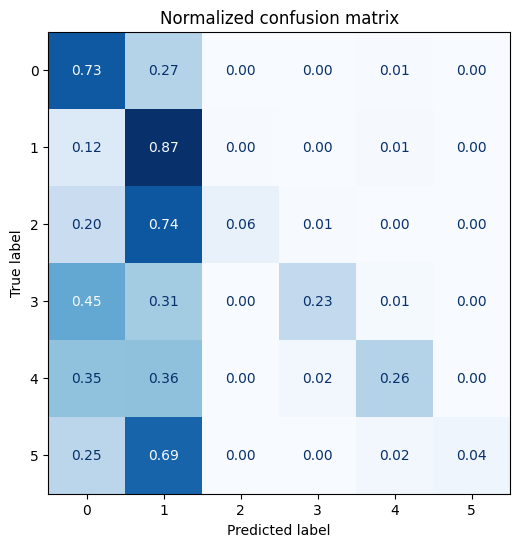

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

plot_confusion_matrix(y_pred, y_val)

In [9]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256),  # You can tune this
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,            # Automatically stop if no improvement
    verbose=True
)

mlp.fit(X_train_scaled, y_train)




Iteration 1, loss = 0.99422453
Validation score: 0.703125
Iteration 2, loss = 0.62287436
Validation score: 0.722500
Iteration 3, loss = 0.43795056
Validation score: 0.715000
Iteration 4, loss = 0.28643420
Validation score: 0.734375
Iteration 5, loss = 0.17582029
Validation score: 0.734375
Iteration 6, loss = 0.09385169
Validation score: 0.741250
Iteration 7, loss = 0.06328837
Validation score: 0.745625
Iteration 8, loss = 0.04115110
Validation score: 0.746250
Iteration 9, loss = 0.02743117
Validation score: 0.742500
Iteration 10, loss = 0.02303151
Validation score: 0.743125
Iteration 11, loss = 0.02011487
Validation score: 0.740000
Iteration 12, loss = 0.01658420
Validation score: 0.738750
Iteration 13, loss = 0.01780224
Validation score: 0.746250
Iteration 14, loss = 0.01520268
Validation score: 0.736250
Iteration 15, loss = 0.01566068
Validation score: 0.743750
Iteration 16, loss = 0.01895427
Validation score: 0.736250
Iteration 17, loss = 0.01562750
Validation score: 0.750000
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(512, 256), max_iter=500,
              random_state=42, verbose=True)

In [10]:
# Predict
y_pred_mlp = mlp.predict(X_val)

# Evaluate
print("📊 MLPClassifier - Classification Report:")
print(classification_report(y_val, y_pred_mlp))

📊 MLPClassifier - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.35      0.51       550
           1       0.59      0.85      0.70       704
           2       0.37      0.66      0.48       178
           3       0.61      0.63      0.62       275
           4       0.70      0.45      0.55       212
           5       0.67      0.38      0.49        81

    accuracy                           0.60      2000
   macro avg       0.65      0.55      0.56      2000
weighted avg       0.68      0.60      0.59      2000

